## Imports

In [259]:
from typing import List, Tuple
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from datetime import datetime, timedelta
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarning from scikit-learn
warnings.simplefilter(action='ignore', category=FutureWarning)

## Utilility Functions

In [260]:
def save_dataframe_to_csv(df: pd.DataFrame, ticker: str, filename: str = None) -> bool:
    """
    Saves a pandas DataFrame to a CSV file.
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input is not a valid or non-empty DataFrame. Nothing to save.")
        return False

    if filename is None:
        filename = f"{ticker}_market_data.csv"

    try:
        # Save the DataFrame to a CSV file.
        # The index (which is the date) is crucial, so we ensure it's saved.
        df.to_csv(filename, index=True)
        print(f"\nDataFrame successfully saved to '{filename}'")
        return True
    except IOError as e:
        # Handle specific file system errors
        print(f"\nAn I/O error occurred while saving the file: {e}")
        return False

In [261]:
# 1. Global Constants
api_key = "v0Y7rqjEfz0nBiixKBqJwLLgyFYbOUGA" # FMP API key

LOOK_BACK = 780       # Number of past time steps the model looks at (approx 3 year months of trading days)
PREDICT_AHEAD = 10    # Number of future time steps the model predicts
EMBED_DIM = 256       # Embedding dimension for the Transformer (must be divisible by NUM_HEADS)
NUM_HEADS = 16        # Number of attention heads (EMBED_DIM / NUM_HEADS = 256 / 16 = 16, which is valid)
FF_DIM = 1024         # Hidden layer size in the feed-forward network
DROPOUT_RATE = 0.2    # Dropout rate for regularization
NUM_TRANSFORMER_BLOCKS = 3 # Number of Transformer Blocks to stack

In [262]:
def calculate_daily_return(df):
    """
    Calculates the daily percentage return from the 'close' prices.
    Adds a 'Daily_Return' column to the DataFrame.
    """
    if 'close' not in df.columns:
        print("Error: 'close' column not found for Daily_Return calculation.")
        df['Daily_Return'] = np.nan
        return df
    print("Calculating Daily_Return...")
    df['Daily_Return'] = df['close'].pct_change()
    return df

def calculate_rsi(df, window=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    exp1 = df['close'].ewm(span=short_window, adjust=False).mean()
    exp2 = df['close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_momentum(df, window=1):
    df['Momentum'] = df['close'].diff(window)
    return df

def calculate_obv(df):
    df['OBV'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    return df

def calculate_atr(df, window=14):
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    # Combine the three True Range components into one DataFrame:
    # 1. high_low: High - Low (intra-day range)
    # 2. high_close: |High - Previous Close| (gap up/down possibility)
    # 3. low_close: |Low - Previous Close| (gap down possibility)
    # Then take the row-wise max to compute the True Range for each day
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.ewm(span=window, adjust=False).mean()
    return df

In [263]:
def get_historical_data_fmp(symbol, start_date, end_date):
    """
    Fetches historical price data from FMP API.
    Calculates start_date based on period_in_quarters from current date.
    Returns a DataFrame with 'open', 'high', 'low', 'close', 'volume' prices and a DatetimeIndex.
    """
    print(f"Fetching historical price data for {symbol} from {start_date} to {end_date} from FMP API...")
    
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start_date}&to={end_date}&apikey={api_key}"
    
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
        data = response.json()

        if 'historical' in data and data['historical']:
            df = pd.DataFrame(data['historical'])
            df['date'] = pd.to_datetime(df['date'])
            df = df.set_index('date').sort_index()
            # Ensure required columns are present and correctly named
            df = df[['open', 'high', 'low', 'close', 'volume']]
            print(f"Successfully fetched {len(df)} historical price records from FMP.")
            return df
        else:
            print(f"FMP API returned no historical price data for {symbol} in the specified period.")
            return pd.DataFrame()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching historical price data from FMP API: {e}")
        return pd.DataFrame()

In [264]:
def get_fundamental_data_fmp(symbol, start_date, end_date):
    """
    Fetches fundamental data (Income Statement, Key Metrics) from FMP API
    and calculates EPS Growth, Revenue Growth, and ROE.
    Returns a DataFrame with fundamental metrics and a DatetimeIndex.
    """

    print(f"Fetching fundamental data for {symbol} from {start_date} to {end_date} from FMP API...")

    fundamental_df_list = []

    try:
        # Fetch Income Statements (quarterly)
        income_url = f"https://financialmodelingprep.com/api/v3/income-statement/{symbol}?period=quarter&apikey={api_key}"
        income_response = requests.get(income_url)
        income_response.raise_for_status()
        income_statements = income_response.json()
        
        income_df = pd.DataFrame(income_statements)
        if not income_df.empty:
            income_df['date'] = pd.to_datetime(income_df['date'])
            income_df = income_df.set_index('date').sort_index()
            
            # Calculate Revenue Growth (Year-over-Year Quarterly)
            # Ensure 'revenue' column exists
            if 'revenue' in income_df.columns:
                income_df['Revenue_Growth'] = income_df['revenue'].pct_change(periods=4) # Compare to same quarter last year
            else:
                income_df['Revenue_Growth'] = np.nan
                print("Warning: 'revenue' column not found in income statements for Revenue_Growth calculation.")

            # Calculate EPS Growth (Year-over-Year Quarterly)
            # Ensure 'eps' column exists
            if 'eps' in income_df.columns:
                income_df['EPS_Growth'] = income_df['eps'].pct_change(periods=4) # Compare to same quarter last year
            else:
                income_df['EPS_Growth'] = np.nan
                print("Warning: 'eps' column not found in income statements for EPS_Growth calculation.")
            
            income_df = income_df[['Revenue_Growth', 'EPS_Growth']]
            fundamental_df_list.append(income_df)
        else:
            print("No income statements found.")

        # Fetch Key Metrics (quarterly) for ROE
        key_metrics_url = f"https://financialmodelingprep.com/api/v3/key-metrics/{symbol}?period=quarter&apikey={api_key}"
        key_metrics_response = requests.get(key_metrics_url)
        key_metrics_response.raise_for_status()
        key_metrics = key_metrics_response.json()

        key_metrics_df = pd.DataFrame(key_metrics)
        if not key_metrics_df.empty:
            key_metrics_df['date'] = pd.to_datetime(key_metrics_df['date'])
            key_metrics_df = key_metrics_df.set_index('date').sort_index()
            # Ensure 'roe' column exists
            if 'roe' in key_metrics_df.columns:
                key_metrics_df['ROE'] = key_metrics_df['roe']
            else:
                key_metrics_df['ROE'] = np.nan
                print("Warning: 'roe' column not found in key metrics for ROE.")
            key_metrics_df = key_metrics_df[['ROE']]
            fundamental_df_list.append(key_metrics_df)
        else:
            print("No key metrics found.")

        if not fundamental_df_list:
            print("No fundamental data could be fetched or processed.")
            return pd.DataFrame()

        # Merge all fundamental dataframes
        merged_fundamental_df = pd.concat(fundamental_df_list, axis=1).sort_index()
        # Filter by date range
        merged_fundamental_df = merged_fundamental_df[(merged_fundamental_df.index >= start_date) & (merged_fundamental_df.index <= end_date)]
        merged_fundamental_df.index.name = 'date'
        print(f"Successfully fetched and processed {len(merged_fundamental_df)} fundamental records from FMP.")
        return merged_fundamental_df

    except requests.exceptions.RequestException as e:
        print(f"Error fetching fundamental data from FMP API: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred during fundamental data processing: {e}")
        return pd.DataFrame()

In [265]:
def prepare_dataframe(symbol, start_date, end_date):
    """
    Prepares a DataFrame with historical price data, calculated technical indicators,
    and merged fundamental data. The date will be set as the DataFrame's index.
    """
    print(f"\n--- Preparing DataFrame for {symbol} from {start_date} to {end_date} ---")
    # Pass the api_key to the data fetching functions
    price_data = get_historical_data_fmp(symbol, start_date, end_date)
    if price_data.empty:
        print("Error: No historical price data found.")
        return None

    df = price_data.copy()
    print(f"Initial price_data shape: {df.shape}")

    # Calculate technical indicators
    df = calculate_rsi(df)
    df = calculate_macd(df)
    df = calculate_momentum(df)
    df = calculate_obv(df)
    df = calculate_atr(df)
    df = calculate_daily_return(df)
    print(f"DataFrame shape after technical indicator calculation: {df.shape}")

    # Drop NaNs that result from initial technical indicator calculations
    # This is crucial before merging fundamental data to ensure proper alignment.
    df.dropna(inplace=True)
    print(f"DataFrame shape after dropping NaNs from indicator calculation: {df.shape}")
    if df.empty:
        print("Error: DataFrame is empty after calculating indicators and dropping NaNs.")
        return None
    
    # Merge with fundamental data (forward-fill)
    # Pass the api_key to the data fetching functions
    fundamental_df = get_fundamental_data_fmp(symbol, start_date, end_date)
    if fundamental_df.empty:
        print("Error: No fundamental data fetched. This might lead to empty fundamental columns.")
        return None 
    #save_dataframe_to_csv(fundamental_df, "cache/" + symbol + "_fundamental")  # Save the fundamental DataFrame to CSV
    print(f"Fundamental data shape: {fundamental_df.shape}")
    if fundamental_df.empty:
        print("Warning: No fundamental data generated by FMP API. This might lead to empty fundamental columns.")

    df = df.reset_index().rename(columns={"index": "date"})
    fundamental_df = fundamental_df.reset_index().rename(columns={"index": "date"})
    
    df_merged = pd.merge(df, fundamental_df, on='date', how='outer')    
    df_merged.set_index('date', inplace=True)
    
    if not df_merged.empty:
        for col in ['EPS_Growth', 'Revenue_Growth', 'ROE']:
            if col in df_merged.columns:
                print(f"  {col}: {df_merged[col].isna().sum()} NaNs")

    df_filled = df_merged.fillna(method='ffill').dropna()
    if not df_filled.empty:
        for col in ['EPS_Growth', 'Revenue_Growth', 'ROE']:
            if col in df_filled.columns:
                print(f"  {col}: {df_filled[col].isna().sum()} NaNs")

    # The final dropna() is crucial for removing any leading NaNs that couldn't be ffilled
    # (e.g., if fundamental data starts much later than price data, or if there are initial NaNs
    # in technical indicators that were not dropped previously).
    df_final = df_filled.dropna()
    df_final.drop(columns=['open', 'high', 'low'], inplace=True)
    df_final.reset_index(inplace=True)
    df_final.set_index('date', inplace=True)
    
    print(f"DataFrame shape after dropping remaining NaNs: {df_final.shape}")

    if df_final.empty:
        print("Error: DataFrame is empty after merging, forward-filling, and dropping NaNs. This might be due to insufficient initial fundamental data or too many leading NaNs.")
        return None

    print(f"DataFrame prepared with {len(df_final)} rows and {len(df_final.columns)} columns.")
    print(f"DataFrame index name: {df_final.index.name}")
    return df_final

In [266]:
# 2. Data Loading and Preprocessing
def preprocess_data(df):
    """
    Separates input and target features, and scales them.

    Args:
        csv_file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: The scaled input features data (X).
            - numpy.ndarray: The scaled target feature data (Y).
            - sklearn.preprocessing.RobustScaler: Scaler fitted on input features.
            - sklearn.preprocessing.MinMaxScaler: Scaler fitted on target feature.
            - list: List of input feature names.
            - list: List of target feature names.
    """ 

    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    # Define input features (used by the model to predict)
    input_features = ['RSI', 'MACD', 'MACD_Signal', 'Momentum', 'OBV', 'ATR', 'Revenue_Growth', 'EPS_Growth', 'ROE']

    # Define the single target feature to be predicted
    target_feature = ['Daily_Return'] # Predicting 'Daily_Return'

    # Select and preprocess input features
    df_input_features = df[input_features]
    df_input_features = df_input_features.fillna(method='ffill').fillna(method='bfill')
    print(f"Input DataFrame shape: {df_input_features.shape}")

    # Select and preprocess target feature
    df_target_feature = df[target_feature]
    df_target_feature = df_target_feature.fillna(method='ffill').fillna(method='bfill')
    print(f"Target DataFrame shape: {df_target_feature.shape}")

    # Initialize separate scalers for input and target features
    scaler_input = RobustScaler()
    scaler_output = MinMaxScaler(feature_range=(0, 1)) # This scaler is for the target

    # Fit and transform input features
    scaled_input_data = scaler_input.fit_transform(df_input_features)

    # Fit and transform target feature
    scaled_target_data = scaler_output.fit_transform(df_target_feature)

    # Get the last known close price from the prepared_df for reconstruction
    last_known_close_price = df['close'].iloc[-1]

    return scaled_input_data, scaled_target_data, scaler_input, scaler_output, input_features, target_feature, last_known_close_price

In [267]:
# 3. Sequence Creation
def create_sequences(input_data, target_data, look_back, predict_ahead):
    """
    Creates input (X) and target (Y) sequences for time series prediction.

    Args:
        input_data (numpy.ndarray): The scaled input features data.
        target_data (numpy.ndarray): The scaled target feature data.
        look_back (int): Number of past time steps to use as input.
        predict_ahead (int): Number of future time steps to predict.

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: Input sequences (X).
            - numpy.ndarray: Target sequences (Y).
    """
    X, Y = [], []
    # Ensure we don't go out of bounds for both input and target data
    # The latest possible starting point for a sequence is when 
    # (i + look_back + predict_ahead) is still within the bounds of the data.
    for i in range(len(input_data) - look_back - predict_ahead + 1):
        # X is the sequence of input features for 'look_back' steps
        X.append(input_data[i:(i + look_back)])
        # Y is the sequence of target feature (Daily_Return) for 'predict_ahead' steps
        Y.append(target_data[(i + look_back):(i + look_back + predict_ahead)])
    return np.array(X), np.array(Y)

In [268]:
#  4.1 Transformer Model Architecture

class MultiHeadSelfAttention(layers.Layer):
    """
    Multi-Head Self-Attention layer as described in the Transformer paper.
    """
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

In [269]:
#  4.2 Transformer Model Architecture

class TransformerBlock(layers.Layer):
    """
    A single Transformer block combining Multi-Head Attention and a Feed-Forward Network.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None): # <--- FIX IS HERE: Add `training=None`
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [270]:
#  4.3 Transformer Model Architecture

class PositionalEmbedding(layers.Layer):
    """
    Positional Embedding layer to inject sequence order information.
    """
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        self.position_embedding = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embedding(positions)
        return inputs * self.scale + embedded_positions

In [271]:
# 5. Model Training
def build_transformer_model(input_shape, output_sequence_length, output_features_count, num_transformer_blocks=1):
    """
    Builds the Transformer model for time series prediction with multiple Transformer blocks.

    Args:
        input_shape (tuple): Shape of the input sequences (look_back, num_input_features).
        output_sequence_length (int): The length of the output sequence (predict_ahead).
        output_features_count (int): The number of features in the output (now 1 for 'Daily_Return').
        num_transformer_blocks (int): The number of TransformerBlock layers to stack.

    Returns:
        keras.Model: The compiled Transformer model.
    """
    inputs = layers.Input(shape=input_shape) # (None, LOOK_BACK, num_input_features)

    x = layers.TimeDistributed(layers.Dense(EMBED_DIM))(inputs) # Shape: (None, LOOK_BACK, EMBED_DIM)

    x = PositionalEmbedding(input_shape[0], EMBED_DIM)(x) # Shape: (None, LOOK_BACK, EMBED_DIM)

    # Stack multiple Transformer blocks
    for _ in range(num_transformer_blocks):
        transformer_block = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT_RATE)
        x = transformer_block(x) # Shape: (None, LOOK_BACK, EMBED_DIM)

    x = layers.Flatten()(x) # Shape: (None, LOOK_BACK * EMBED_DIM)

    outputs = layers.Dense(output_sequence_length * output_features_count)(x) # Shape: (None, PREDICT_AHEAD * 1)

    outputs = layers.Reshape((output_sequence_length, output_features_count))(outputs) # Shape: (None, PREDICT_AHEAD, 1)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [272]:
# Function for plotting training history
def plot_training_history(history):
    """
    Plots the training and validation loss from the model training history.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [273]:
# Function for plotting returns distribution
def plot_returns_distribution(actual_df, predicted_returns_array, target_feature_name='Daily_Return'):
    """
    Plots the distribution of actual daily returns (from a relevant historical period)
    and predicted daily returns.

    Args:
        actual_df (pd.DataFrame): The DataFrame containing the actual historical data,
                                  including the 'Daily_Return' column.
        predicted_returns_array (numpy.ndarray): The predicted future daily returns (unscaled).
                                                  Shape: (PREDICT_AHEAD, 1).
        target_feature_name (str): The name of the target feature column in actual_df.
    """
    plt.figure(figsize=(12, 7))

    if target_feature_name in actual_df.columns:
        actual_daily_returns_for_plot = actual_df[target_feature_name].iloc[-LOOK_BACK:].dropna() # Use last LOOK_BACK for reference
    else:
        print(f"Warning: '{target_feature_name}' not found in actual_df. Cannot plot actual returns distribution.")
        actual_daily_returns_for_plot = pd.Series([]) # Empty series

    predicted_daily_returns_flat = predicted_returns_array.flatten()

    if not actual_daily_returns_for_plot.empty:
        sns.histplot(actual_daily_returns_for_plot, kde=True, color='blue', label='Actual Daily Returns (Recent History)', stat='density', alpha=0.6)
    sns.histplot(predicted_daily_returns_flat, kde=True, color='red', label='Predicted Daily Returns (Future)', stat='density', alpha=0.6)

    plt.title('Distribution of Actual vs. Predicted Daily Returns')
    plt.xlabel('Daily Return')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


In [274]:
# 5. Training Function
def train_transformer_ts(X_scaled, Y_scaled, input_features_count, output_features_count, look_back, predict_ahead, epochs=50, batch_size=32, num_transformer_blocks=1):
    """
    Trains the Transformer time series prediction model.

    Args:
        X_scaled (numpy.ndarray): The scaled input sequences.
        Y_scaled (numpy.ndarray): The scaled target sequences.
        input_features_count (int): Number of features in the input data.
        output_features_count (int): Number of features in the output (target) data (now 1).
        look_back (int): The sequence length for inputs.
        predict_ahead (int): The sequence length for outputs (predictions).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        num_transformer_blocks (int): Number of Transformer blocks to use in the model.

    Returns:
        keras.Model: The trained Transformer model.
    """
    model = build_transformer_model(
        input_shape=(look_back, input_features_count),
        output_sequence_length=predict_ahead,
        output_features_count=output_features_count,
        num_transformer_blocks=num_transformer_blocks
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    # Define the EarlyStopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        mode='min',          # We want to minimize the validation loss
        patience=10,         # Number of epochs with no improvement
        min_delta=0.00001,   # Minimum change to qualify as an improvement (adjust based on your loss scale)
        restore_best_weights=True, # Restore model weights from the epoch with the best value
        verbose=1            # Print a message when early stopping occurs
    )

    print(f"Training Transformer model for {epochs} epochs with {num_transformer_blocks} blocks...")
    # It's highly recommended to use a validation split to monitor for overfitting
    history = model.fit(
        X_scaled,
        Y_scaled,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        validation_split=0.2, # Use a validation split from the training data
        callbacks=[early_stopping] # Add the early stopping callback here
    )
    print("Training complete.")
    # You might want to return history as well if you want to plot loss curves
    return model, history # Returning history for completeness


In [275]:
# --- 6. Prediction Function ---
def predict_future_values(model, last_input_sequence_scaled, scaler_output):
    """
    Predicts future values using the trained Transformer model.

    Args:
        model (keras.Model): The trained Transformer model.
        last_input_sequence_scaled (numpy.ndarray): The last sequence of input data, scaled.
                                                    Shape: (look_back, num_input_features) before expansion.
        scaler_output (sklearn.preprocessing.MinMaxScaler): The scaler used for the single target feature.

    Returns:
        numpy.ndarray: The inverse-transformed predicted future values.
                       Shape: (predict_ahead, 1).
    """
    # Ensure the input sequence has the correct shape for prediction (batch_size, look_back, num_input_features)
    if last_input_sequence_scaled.ndim == 2:
        last_input_sequence_scaled = np.expand_dims(last_input_sequence_scaled, axis=0)

    # Make prediction
    predicted_scaled = model.predict(last_input_sequence_scaled, verbose=0)
    # After prediction, predicted_scaled will have shape (1, PREDICT_AHEAD, 1)

    # Reshape the predicted output to 2D for inverse transformation: (PREDICT_AHEAD, 1)
    # The scaler expects a 2D array where columns are features. Since we have 1 feature,
    # we reshape from (1, PREDICT_AHEAD, 1) to (PREDICT_AHEAD, 1).
    predicted_scaled_2d = predicted_scaled.reshape(predicted_scaled.shape[1], predicted_scaled.shape[2])

    # Inverse transform the prediction
    predicted_original = scaler_output.inverse_transform(predicted_scaled_2d)

    # predicted_original is already (PREDICT_AHEAD, 1) after inverse_transform, no further reshape needed if it's the only target
    # However, the line below is robust if shape[1] is PREDICT_AHEAD and shape[2] is 1.
    # It's technically redundant if predicted_scaled_2d was already (PREDICT_AHEAD, 1)
    # but doesn't hurt.
    # If you want to explicitly ensure (PREDICT_AHEAD, 1) without relying on reshape's behavior:
    # predicted_original = predicted_original.flatten().reshape(-1, 1)
    # Or simply: return predicted_original if it's already (PREDICT_AHEAD, 1)

    return predicted_original

In [276]:
def reconstruct_prices_dataframe(last_known_close_price, future_dates, predicted_daily_returns):
    """
    Reconstructs future close prices from predicted daily returns and creates a DataFrame.

    Args:
        last_known_close_price (float): The actual closing price of the last day in the input sequence.
        future_dates (pd.DatetimeIndex or list of datetime): The dates for the future predictions.
        predicted_daily_returns (numpy.ndarray): The predicted daily returns (unscaled).
                                                  Shape: (PREDICT_AHEAD, 1).

    Returns:
        pd.DataFrame: A DataFrame with 'date', 'predicted daily return', and 'predicted price'.
    """
    future_close_prices = []
    current_price = last_known_close_price
    
    # Ensure predicted_daily_returns is flat for iteration
    predicted_daily_returns_flat = predicted_daily_returns.flatten()

    for i in range(len(predicted_daily_returns_flat)):
        daily_return = predicted_daily_returns_flat[i] if not np.isnan(predicted_daily_returns_flat[i]) else 0.0
        current_price = current_price * (1 + daily_return)
        future_close_prices.append(current_price)
    
    # Create the DataFrame
    reconstructed_df = pd.DataFrame({
        'date': future_dates,
        'predicted daily return': predicted_daily_returns_flat,
        'predicted price': future_close_prices
    })
    
    return reconstructed_df

In [277]:
def plot_actual_vs_predicted(actual_df, predicted_df, actual_price_col='close', predicted_price_col='predicted price'):
    """
    Plots actual vs. predicted stock prices.

    Args:
        actual_df (pd.DataFrame): DataFrame containing actual historical data.
                                  Must have a 'date' column (or index) and the actual_price_col.
        predicted_df (pd.DataFrame): DataFrame containing predicted future data.
                                   Must have a 'date' column and the predicted_price_col.
        actual_price_col (str): The name of the column containing actual prices in actual_df.
        predicted_price_col (str): The name of the column containing predicted prices in predicted_df.
    """
    plt.figure(figsize=(14, 7))

    # Ensure date is a column and datetime type for plotting
    if 'date' not in actual_df.columns and isinstance(actual_df.index, pd.DatetimeIndex):
        plot_actual_df = actual_df.reset_index()
    else:
        plot_actual_df = actual_df.copy()
    plot_actual_df['date'] = pd.to_datetime(plot_actual_df['date'])

    plot_predicted_df = predicted_df.copy()
    plot_predicted_df['date'] = pd.to_datetime(plot_predicted_df['date'])

    # Plot actual prices
    plt.plot(plot_actual_df['date'], plot_actual_df[actual_price_col], label='Actual Prices', color='blue')

    # Plot predicted prices
    plt.plot(plot_predicted_df['date'], plot_predicted_df[predicted_price_col], label='Predicted Prices', color='red', linestyle='--')

    plt.title('Actual vs. Predicted Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


--- Preparing DataFrame for AAPL from 2010-01-01 to 2024-12-31 ---
Fetching historical price data for AAPL from 2010-01-01 to 2024-12-31 from FMP API...
Successfully fetched 3774 historical price records from FMP.
Initial price_data shape: (3774, 5)
Calculating Daily_Return...
DataFrame shape after technical indicator calculation: (3774, 12)
DataFrame shape after dropping NaNs from indicator calculation: (3761, 12)
Fetching fundamental data for AAPL from 2010-01-01 to 2024-12-31 from FMP API...
Successfully fetched and processed 60 fundamental records from FMP.
Fundamental data shape: (60, 3)
  EPS_Growth: 3761 NaNs
  Revenue_Growth: 3761 NaNs
  ROE: 3761 NaNs
  EPS_Growth: 0 NaNs
  Revenue_Growth: 0 NaNs
  ROE: 0 NaNs
DataFrame shape after dropping remaining NaNs: (3776, 12)
DataFrame prepared with 3776 rows and 12 columns.
DataFrame index name: date
Input DataFrame shape: (3776, 9)
Target DataFrame shape: (3776, 1)
Training Transformer model for 1 epochs with 3 blocks...
75/75 ━━━━━

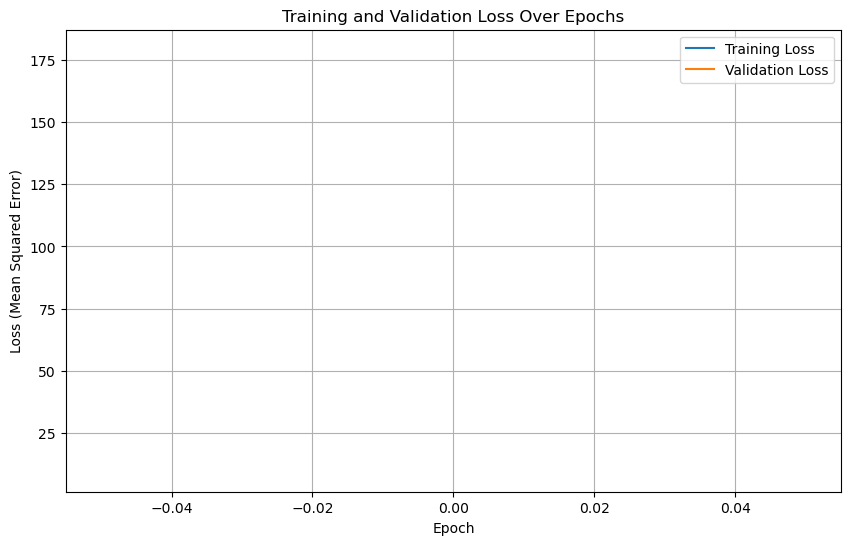


Predicted Future Values (original scale) for next 10 steps for 'Daily_Return':
Predicted DataFrame from 2025-01-01 to 2025-01-14:

Fetching historical price data for AAPL from 2025-01-01 to 2025-01-14 from FMP API...
Successfully fetched 8 historical price records from FMP.

DataFrame successfully saved to 'data/AAPL_actual_market_data.csv'


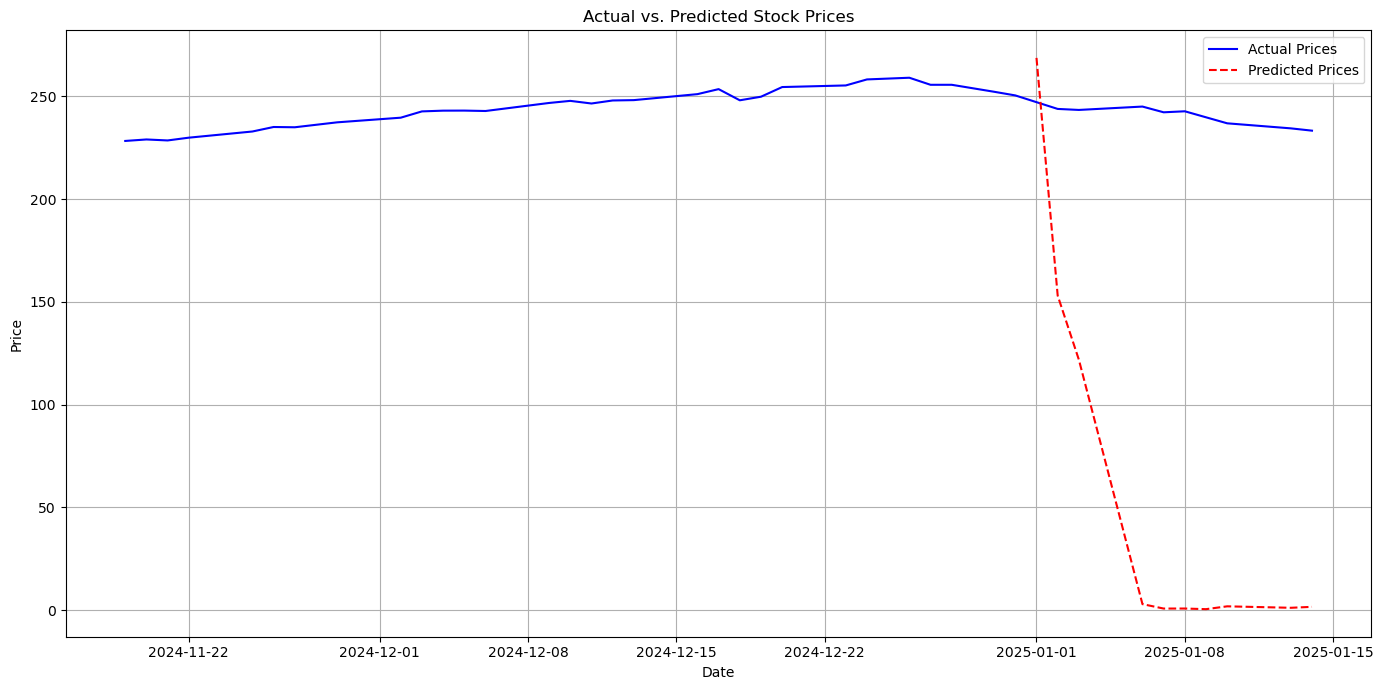

        date  predicted daily return  predicted price
0 2025-01-01                0.072878       268.669985
1 2025-01-02               -0.430290       153.064053
2 2025-01-03               -0.203866       121.859457
3 2025-01-06               -0.975325         3.006898
4 2025-01-07               -0.716865         0.851357
5 2025-01-08                0.018782         0.867348
6 2025-01-09               -0.358127         0.556727
7 2025-01-10                2.474753         1.934490
8 2025-01-13               -0.368253         1.222108
9 2025-01-14                0.376679         1.682450

Plotting Returns Distribution...{last_known_date} to {predicted_end_date}
Fetching historical price data for AAPL from 2024-12-31 to 2025-01-14 from FMP API...
Successfully fetched 9 historical price records from FMP.
Calculating Daily_Return...


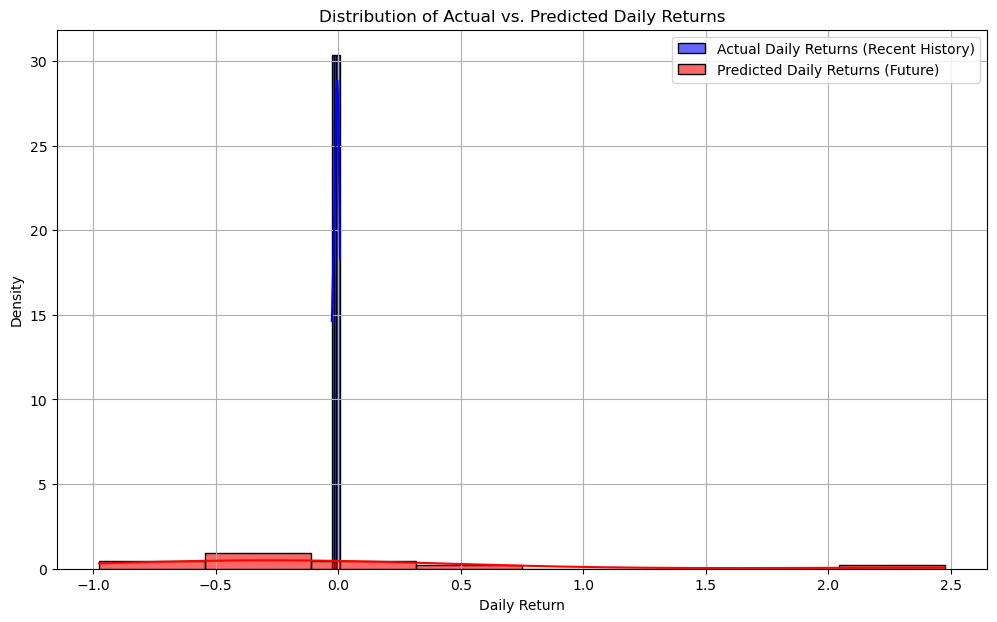

              open    high     low   close    volume  Daily_Return
date                                                              
2024-12-31  252.44  253.28  249.43  250.42  39480718           NaN
2025-01-02  248.93  249.10  241.82  243.85  55740731     -0.026236
2025-01-03  243.36  244.18  241.89  243.36  40244114     -0.002009
2025-01-06  244.31  247.33  243.20  245.00  45045600      0.006739
2025-01-07  242.98  245.55  241.35  242.21  40856000     -0.011388
2025-01-08  241.92  243.71  240.05  242.70  37628940      0.002023
2025-01-10  240.01  240.16  233.00  236.85  61710900     -0.024104
2025-01-13  233.53  234.67  229.72  234.40  49630725     -0.010344
2025-01-14  234.75  236.12  232.47  233.28  39435300     -0.004778


In [ ]:
if __name__ == '__main__':
    symbol_to_process = "AAPL"
    end_date = "2024-12-31"
    start_date = "2010-01-01"

    prepared_df = prepare_dataframe(symbol_to_process, start_date, end_date)
    if prepared_df is None: # Handle case where prepare_dataframe returns None
        print("DataFrame preparation failed. Exiting.")
        exit()
    prepared_df.reset_index(inplace=True)

    scaled_input_data, scaled_target_data, scaler_input, scaler_output, input_features_list, target_features_list, last_known_close_price = preprocess_data(prepared_df)

    NUM_INPUT_FEATURES = scaled_input_data.shape[1]
    NUM_TARGET_FEATURES = scaled_target_data.shape[1]

    X, Y = create_sequences(scaled_input_data, scaled_target_data, LOOK_BACK, PREDICT_AHEAD)

    if X.shape[0] > 0:
        # Train the model and get the history object
        model, history = train_transformer_ts(
            X_scaled=X,
            Y_scaled=Y,
            input_features_count=NUM_INPUT_FEATURES,
            output_features_count=NUM_TARGET_FEATURES,
            look_back=LOOK_BACK,
            predict_ahead=PREDICT_AHEAD,
            epochs=300, # Use a sufficiently large number, early stopping will manage it
            batch_size=32,
            num_transformer_blocks=NUM_TRANSFORMER_BLOCKS
        )

        # Plotting Training History
        plot_training_history(history)

        last_input_sequence_scaled = scaled_input_data[-LOOK_BACK:]
        if last_input_sequence_scaled.shape[0] == LOOK_BACK:
            predicted_future_values = predict_future_values(model, last_input_sequence_scaled, scaler_output)
            print(f"\nPredicted Future Values (original scale) for next {PREDICT_AHEAD} steps for '{target_features_list[0]}':")
        
            last_known_date = prepared_df['date'].iloc[-1]
            future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1),
                                        periods=PREDICT_AHEAD,
                                        freq='B')
        
            predicted_df = reconstruct_prices_dataframe(
                        last_known_close_price, future_dates, predicted_future_values)
            predicted_start_date = predicted_df['date'].min().date()
            predicted_end_date = predicted_df['date'].max().date()            
            print(f"Predicted DataFrame from {predicted_start_date} to {predicted_end_date}:\n")            
            actual_df_for_plot = get_historical_data_fmp(symbol_to_process, predicted_start_date, predicted_end_date)
            save_dataframe_to_csv(actual_df_for_plot, "data/" + symbol_to_process + "_actual") # No need to save if just plotting

            if actual_df_for_plot.empty:
                print("Error: No historical data available for plotting for the predicted period.")
            else:
                plot_actual_df = prepared_df.set_index('date')['close'].tail(30).to_frame()
                plot_actual_df.index.name = 'date'
                plot_actual_df = pd.concat([plot_actual_df, actual_df_for_plot['close'].to_frame()])

                plot_actual_vs_predicted(plot_actual_df, predicted_df, actual_price_col='close', predicted_price_col='predicted price')               
            print(predicted_df)

            # Plotting Returns Distribution
            print("\nPlotting Returns Distribution...{last_known_date} to {predicted_end_date}")
            actual_df_for_return_plot = get_historical_data_fmp(symbol_to_process, last_known_date.date(), predicted_end_date)
            calculate_daily_return(actual_df_for_return_plot)
            actual_df_for_plot.dropna(inplace=True)            
            plot_returns_distribution(actual_df_for_return_plot, predicted_future_values, target_feature_name='Daily_Return')
            print(actual_df_for_return_plot)


        else:
            print("Not enough data to create the last input sequence for prediction.")
    else:
        print("Not enough data to create sequences for training and prediction. Adjust LOOK_BACK or PREDICT_AHEAD constants or provide more data.")